# Generative Models

This notebook gives a quick example on how to use the transpose pseudo convolutions in DeepSphere to train a simple auto-encoder.

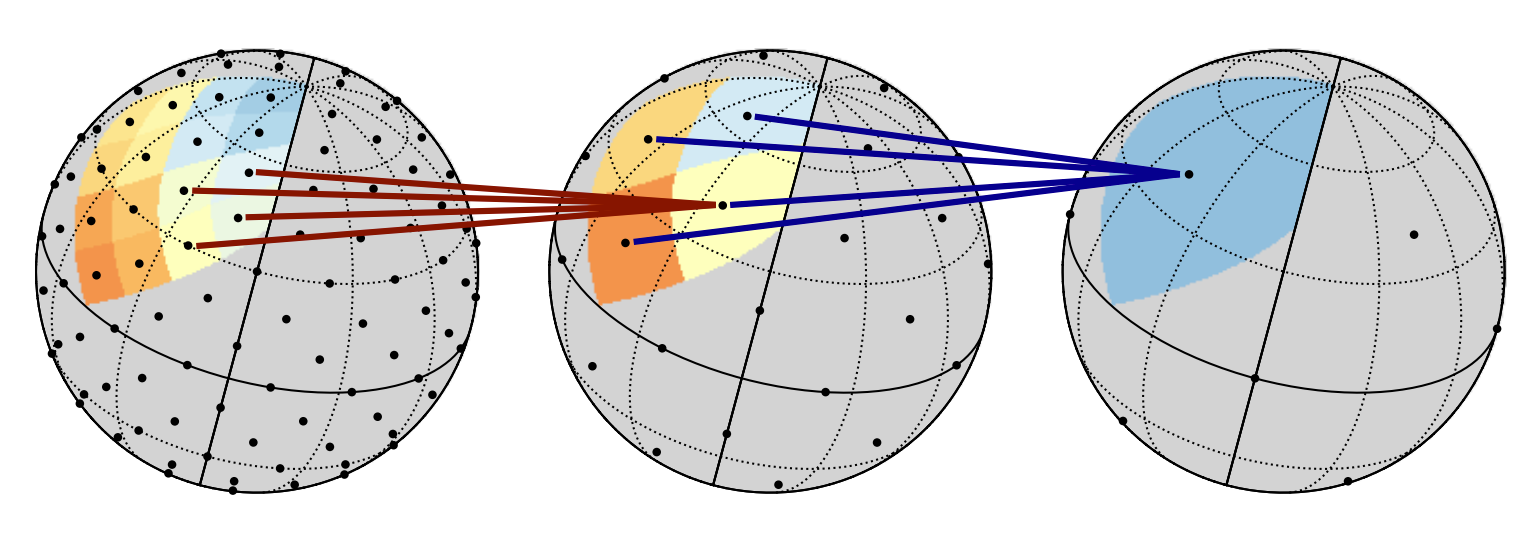

The transpose pseudo convolutions use the healpy pixelization scheme to increase the nside of the data, making them useful for generative models.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

## 1 Data loading

The data consists of a toy dataset that is sufficiently small to have fun with.
It is made of 200 maps of size `nside=64` splitted in 2 classes. 

The maps contain Gaussian random field realisations produced by the `synfast` function from `healpy`.
The input power spectra were taken from a ΛCDM model with two sets of parameters.
These maps are not realistic cosmological mass maps, just a toy dataset.
We downsampled them to `nside=64` to make processing faster.

In [2]:
data = np.load('../data/maps_downsampled_64.npz')
assert(len(data['class1']) == len(data['class2']))
nclass = len(data['class1'])

We only need the first class in this notebook. Further, we will smooth the data a bit.

In [3]:
training_data = []
for m in data['class1']:
    m = hp.reorder(m, n2r=True)
    m = hp.smoothing(m, fwhm=.05, verbose=False)
    m = hp.reorder(m, r2n=True)
    training_data.append(100*m.astype(np.float32)[:,None])
training_data = np.array(training_data)

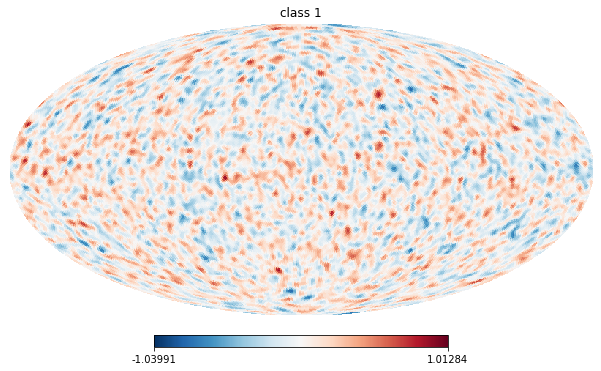

In [4]:
cmin = np.min(training_data)
cmax = np.max(training_data)
cm = plt.cm.RdBu_r
hp.mollview(training_data[0,:,0], title='class 1', nest=True, cmap=cm, min=cmin, max=cmax)

## 2 A simple auto encoder

We implement a simple auto-encoder class and train it on the maps.

In [5]:
class auto_encoder(tf.keras.Model):
    def __init__(self, encoder_layer, decoder_layer, nside, indices):
        """
        Inits the auto-encoder with layers for the encoder and the decoder
        """
        # this line is necessary for all Model subclasses
        super(auto_encoder, self).__init__(name="")
        
        # save some properties
        self.nside = nside
        self.indices = indices
        
        # init the encoder and the decoder
        print("Initializing the encoder...")
        self.encoder = HealpyGCNN(nside=nside, indices=indices, layers=encoder_layer,
                                  n_neighbors=20)
        
        # get the bottle neck nside and indices
        self.bottle_neck_nside = self.encoder.nside_out
        self.bottle_neck_indices = self.encoder._transform_indices(nside_in=self.nside, 
                                                        nside_out=self.bottle_neck_nside, 
                                                        indices=self.indices)
        
        print("Initializing the decoder...")
        self.decoder = HealpyGCNN(nside=self.bottle_neck_nside, 
                                  indices=self.bottle_neck_indices, 
                                  layers=decoder_layer, n_neighbors=20)
        
    def summary(self, *args, **kwargs):
        """
        A wrapper for the summary routines of the decoder and encoder
        """
        print("Encoder summary:")
        self.encoder.summary(*args, **kwargs)
        print("Decoder summary:")
        self.decoder.summary(*args, **kwargs)
        
    def call(self, input_tensor, training=False, *args, **kwargs):
        """
        Calls the autoencoder
        """
        bottle_neck = self.encoder(input_tensor, training=training, *args, **kwargs)
        reconstruction = self.decoder(bottle_neck, training=training, *args, **kwargs)
        
        return reconstruction

Now we define some layers for the encoder and the decoder.

In [6]:
K = 5
encoder_layers = [hp_layer.HealpyPseudoConv(p=1, Fout=4, activation="elu"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=8, activation="elu"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),]

decoder_layers = [hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=1, activation="linear")]

We initialize the model.

In [7]:
nside = 64
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
model = auto_encoder(encoder_layers, decoder_layers, nside, indices)
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

Initializing the encoder...
Detected a reduction factor of 8.0, the input with nside 64 will be transformed to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Initializing the decoder...
Detected a reduction factor of 0.125, the input with nside 8 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Encoder summary:
Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
healpy_pseudo_conv (HealpyPseudoConv)            (None, 12288, 4)                            20               
______________________________________________________________________________________________________________
healpy_pseudo_conv_1 (HealpyPseudoConv)          (None, 3072, 8)                             136          

Note that for this simple toy model we chose a bottleneck that is only 4 times smaller than the input data.

## 3 Training the model

We use again the `model.compile()` and `model.fit()` routines to train the model. Note that we leave out a training and validation data split.

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss="MAE",
              metrics=["MAE"],
)

In [9]:
print("Fit model on training data")
history = model.fit(
    x=training_data,
    y=training_data,
    batch_size=5,
    epochs=50,
)

Fit model on training data
Epoch 1/50
20/20 [==============================] - 7s 367ms/step - loss: 0.1379 - MAE: 0.1379
Epoch 2/50
20/20 [==============================] - 10s 491ms/step - loss: 0.1006 - MAE: 0.1006
Epoch 3/50
20/20 [==============================] - 11s 526ms/step - loss: 0.0919 - MAE: 0.0919
Epoch 4/50
20/20 [==============================] - 8s 384ms/step - loss: 0.0880 - MAE: 0.0880
Epoch 5/50
20/20 [==============================] - 7s 368ms/step - loss: 0.0849 - MAE: 0.0849
Epoch 6/50
20/20 [==============================] - 6s 304ms/step - loss: 0.0790 - MAE: 0.0790
Epoch 7/50
20/20 [==============================] - 7s 335ms/step - loss: 0.0757 - MAE: 0.0757
Epoch 8/50
20/20 [==============================] - 8s 416ms/step - loss: 0.0707 - MAE: 0.0707
Epoch 9/50
20/20 [==============================] - 9s 452ms/step - loss: 0.0672 - MAE: 0.0672
Epoch 10/50
20/20 [==============================] - 8s 399ms/step - loss: 0.0655 - MAE: 0.0655
Epoch 11/50
20/20 [=

Let's have a look at a reconstructed image.

In [10]:
original_map = training_data[:1]
reconstructed_map = model(original_map, True).numpy()

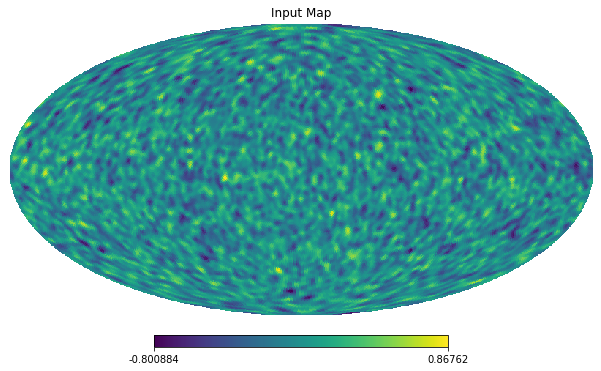

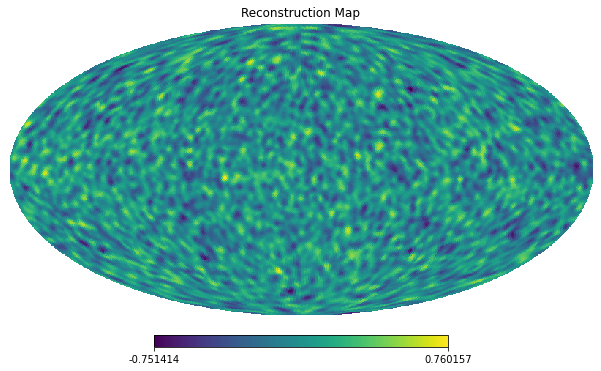

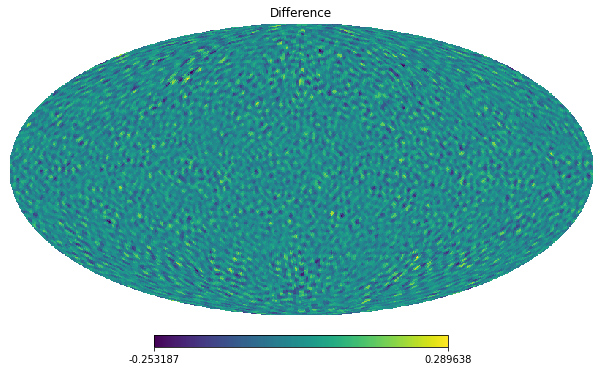

In [11]:
hp.mollview(original_map[0,:,0], nest=True, title="Input Map")
hp.mollview(reconstructed_map[0,:,0], nest=True, title="Reconstruction Map")
hp.mollview(original_map[0,:,0] - reconstructed_map[0,:,0], nest=True, title="Difference")

Let's take a look at the loss during training.

Text(0, 0.5, 'Loss')

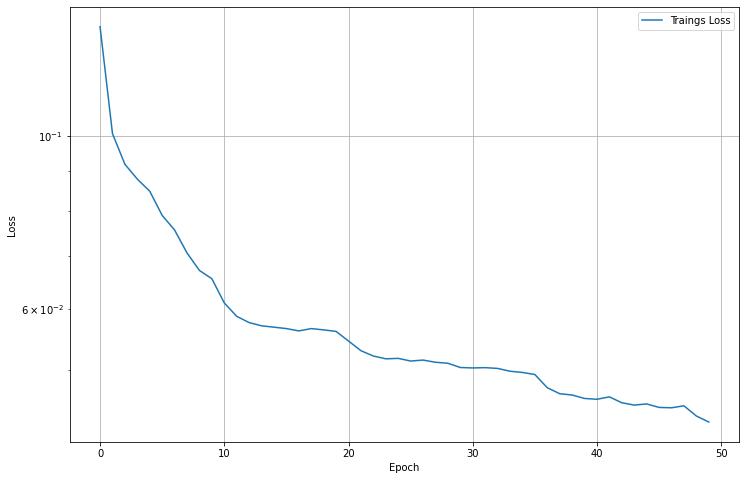

In [12]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="Traings Loss")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")